# density and baseline setting to mutations

In [2]:
import os
import re
import pandas as pd
import seaborn as sns
from Bio import *
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from Bio import SeqIO
import traceback

In [3]:
all_snps_df = pd.read_csv('final_df.csv').drop('Unnamed: 0', axis = 1)
big_intergenic_df = pd.read_csv('big_intergenic_df.csv')

In [4]:
references = all_snps_df.loc[:, 'reference'].unique()
reads = all_snps_df.loc[:, 'reads'].unique()

## make big dataframe

### set the threshold

In [5]:
window = 100
times_average_parameter = 6

references = all_snps_df.loc[:, 'reference'].unique()
unique_reads = all_snps_df.loc[:, 'reads'].unique()

significant_mutations_array = []
read_ref_snp_df_filled_array = []

#first, loop over all the references
for i in range(len(references)): 
    for ii in range(len(unique_reads)): 
        reference = references[i]
        reads = unique_reads[ii]
        ref_snp_df = all_snps_df[all_snps_df.loc[:, 'reference'] == reference]
        read_ref_snp_df = ref_snp_df[ref_snp_df.loc[:, 'reads'] == reads]
        read_ref_snp_df = read_ref_snp_df[['POS', 'reference', 'reads', 'morphology reference', 'morphology reads', 'error']]

        #make the filled dataframe
        if read_ref_snp_df.shape[0] != 0: 
            start = read_ref_snp_df.loc[:, 'POS'].min()
            stop = read_ref_snp_df.loc[:, 'POS'].max()
            index = np.arange(start, stop+1, 1)

            #fill up the array
            read_ref_snp_df_filled = pd.DataFrame(index).rename({0: 'POS'}, axis = 1)
            read_ref_snp_df_filled = pd.merge(read_ref_snp_df_filled, read_ref_snp_df, 'outer')
            read_ref_snp_df_filled.loc[:, 'snp'] = read_ref_snp_df_filled.loc[:, 'error'].notna()

            #calculate the density
            read_ref_snp_df_filled.loc[:, 'density'] =  read_ref_snp_df_filled.loc[:, 'snp'].rolling(window = window).sum()
            #calculate the average of the density
            average = read_ref_snp_df_filled.loc[:, 'density'].mean()
            #calculate how many times a certain density is the average
            read_ref_snp_df_filled.loc[:, 'times average'] = read_ref_snp_df_filled.loc[:, 'density']/average
            read_ref_snp_df_filled_array = read_ref_snp_df_filled_array + [read_ref_snp_df_filled]

#             #take the positions for which the reference is 'special', in a way that there are a lot of mutations on those sites, compared to the reference
#             filt_read_ref_snp_df_filled = read_ref_snp_df_filled[read_ref_snp_df_filled.loc[:, 'density'] > times_average_parameter*average].dropna()

#             significant_mutations_array = significant_mutations_array + [filt_read_ref_snp_df_filled]
# significant_pos_df = pd.concat(significant_mutations_array, ignore_index=True)
all_snp_pos = pd.concat(read_ref_snp_df_filled_array, ignore_index=True)

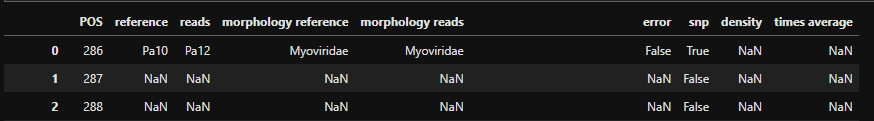

### make barcode plot

In [8]:
ref_gene_positions = big_intergenic_df[big_intergenic_df.loc[:, 'phage'] == phage]
ref_gene_positions.loc[:, 'middle of gene'] = (ref_gene_positions.loc[:, 'gene stop'] - ref_gene_positions.loc[:, 'gene start'])/2
ref_gene_positions

C:\Users\Halewijn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,gene start,gene stop,complement,protein translation,protein annotation,product,ID,phage,middle of gene
1656,0,513,1,['IEHNDAPGLKRTSKPGVSGMEPSVFSSNRIVGPRDHSELQRIKV...,['SEED:fig|287.19300.peg.1'],['Phage protein'],287.193,Pa33,256.5
1657,512,1349,1,['MAFKASKKRERRAPLPVGRGKPIIPSAGIEAWYRKQMKDMSKLM...,['SEED:fig|287.19300.peg.2'],['Phage minor capsid protein'],287.193,Pa33,418.5
1658,1367,1574,1,['MPLVHGTSNEARSENIQREIEAGKDPKQAAAIAYSIQRSEKGKM...,['SEED:fig|287.19300.peg.3'],['Phage protein'],287.193,Pa33,103.5
1659,1570,1711,1,['MNRKTCRRRLVVDVIRANIHGGFFNLKFAVIDLAIIGVAILMAF...,['SEED:fig|287.19300.peg.4'],['hypothetical protein'],287.193,Pa33,70.5
1660,2224,3658,1,['MAKSKRKIDENGYMTIEGCPISSYGVFQYSAGQLGLPGDPTRIV...,['SEED:fig|287.19300.peg.5'],['Phage protein'],287.193,Pa33,717.0
...,...,...,...,...,...,...,...,...,...
1745,62777,63089,-1,['MKYVVLKMTVRGMSREVPVIFPDLIRHVNMAASAVVALDAECED...,['SEED:fig|287.19300.peg.90'],['hypothetical protein'],287.193,Pa33,156.0
1746,63094,63298,-1,['MKPRRPEVRVSLETALWMSTSAALLAAIIAGAVFPPSTIQCPEE...,['SEED:fig|287.19300.peg.91'],['hypothetical protein'],287.193,Pa33,102.0
1747,63294,63618,-1,['MASITVWIATAFLCTGDGCVQIPDHTSRRFDSKTQCEDVMLRAI...,['SEED:fig|287.19300.peg.92'],['hypothetical protein'],287.193,Pa33,162.0
1748,63648,64050,-1,['MNTLLPIVHIVLKDGEVLGVFDCDKSARLFRDMKGGVLDSWVVE...,['SEED:fig|287.19300.peg.93'],['hypothetical protein'],287.193,Pa33,201.0


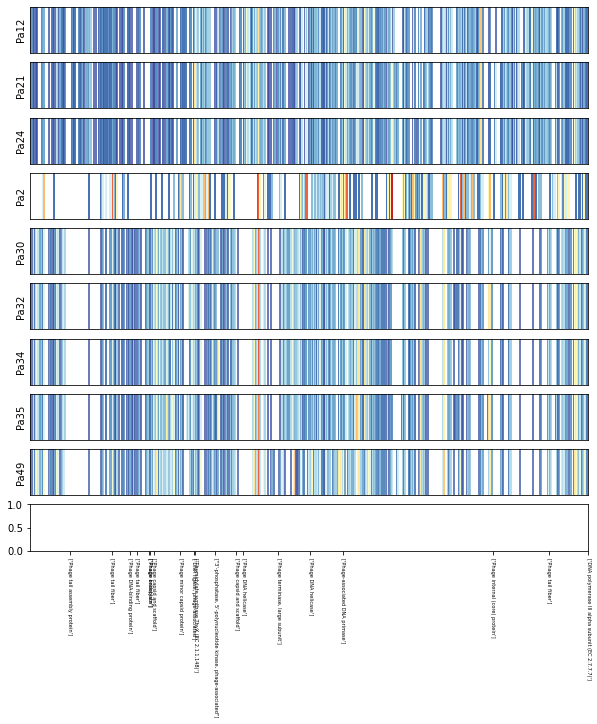

In [31]:
phage = 'Pa33'
ref_all_snp_pos = all_snp_pos[all_snp_pos.loc[:, 'reference'] == phage]
minimum = ref_all_snp_pos.loc[:, 'POS'].min()
maximum = ref_all_snp_pos.loc[:, 'POS'].max()
minimum_average = ref_all_snp_pos.loc[:, 'times average'].min()
maximum_average = ref_all_snp_pos.loc[:, 'times average'].max()

reads_array = ref_all_snp_pos.loc[:, 'reads'].unique()

fig, axes = plt.subplots(len(reads_array),1, figsize =(10,10))
#define the colormap 
cmap = plt.cm.get_cmap('RdYlBu_r')


for i in range(len(reads_array)): 
    reads = reads_array[i]
    read_ref_all_snp_pos = ref_all_snp_pos[ref_all_snp_pos.loc[:, 'reads'] == reads].reset_index()

    # only one line may be specified; full height
    for ii in range(read_ref_all_snp_pos.shape[0]): 
        position = read_ref_all_snp_pos.loc[ii, 'POS']
        times_average = read_ref_all_snp_pos.loc[ii, 'times average']
        norm_times_average = (times_average-minimum_average)/maximum_average
        color = cmap(norm_times_average)
        try: 
            if i == len(reads_array)-1:
                continue
                #axes[i].set_xticks(ref_gene_positions.loc[:, 'middle of gene'], ref_gene_positions.loc[:, 'product'])
            else:   
                axes[i].axvline(x = position, color = color, label = 'axvline - full height')
                axes[i].set_ylabel(reads, rotation = 90)    
                axes[i].set_xlim(minimum, maximum)
                axes[i].set_yticks([])
                axes[i].set_xticks([])


        except: 
            continue
    axes[i].set
fig = plt.gcf()
ax = plt.gca()
label_df = ref_gene_positions[(ref_gene_positions.loc[:, 'product'] != "['hypothetical protein']") & (ref_gene_positions.loc[:, 'product'] != "['Phage protein']")]
axes[i].set_xticks(label_df.loc[:, 'middle of gene'])
axes[i].set_xticklabels(label_df.loc[:, 'product'], rotation = -90, fontdict = {'fontsize':5})
plt.show()

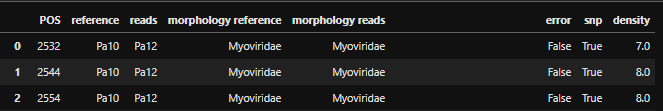

10
Pa10
None
0
nan
None


ValueError: Number of rows must be a positive integer, not 0

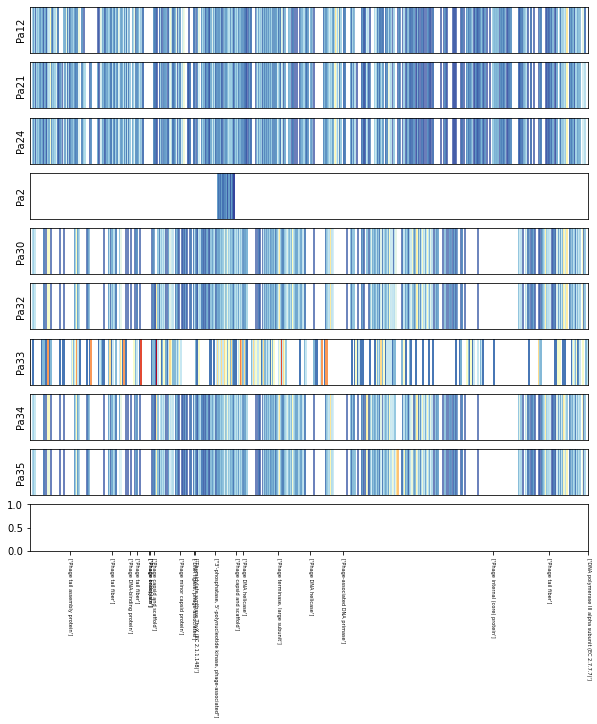

<Figure size 720x720 with 0 Axes>

In [34]:
phages = all_snp_pos.loc[:, 'reference'].unique()
for h in range(len(phages)): 
    phage = phages[h]
    ref_all_snp_pos = all_snp_pos[all_snp_pos.loc[:, 'reference'] == phage]
    minimum = ref_all_snp_pos.loc[:, 'POS'].min()
    maximum = ref_all_snp_pos.loc[:, 'POS'].max()
    minimum_average = ref_all_snp_pos.loc[:, 'times average'].min()
    maximum_average = ref_all_snp_pos.loc[:, 'times average'].max()

    reads_array = ref_all_snp_pos.loc[:, 'reads'].unique()
    print(len(reads_array))
    print(print(phage))
    fig, axes = plt.subplots(len(reads_array),1, figsize =(10,10))
    #define the colormap 
    cmap = plt.cm.get_cmap('RdYlBu_r')


    for i in range(len(reads_array)): 
        reads = reads_array[i]
        read_ref_all_snp_pos = ref_all_snp_pos[ref_all_snp_pos.loc[:, 'reads'] == reads].reset_index()

        # only one line may be specified; full height
        for ii in range(read_ref_all_snp_pos.shape[0]): 
            position = read_ref_all_snp_pos.loc[ii, 'POS']
            times_average = read_ref_all_snp_pos.loc[ii, 'times average']
            norm_times_average = (times_average-minimum_average)/maximum_average
            color = cmap(norm_times_average)
            try: 
                if i == len(reads_array)-1:
                    continue
                    #axes[i].set_xticks(ref_gene_positions.loc[:, 'middle of gene'], ref_gene_positions.loc[:, 'product'])
                else:   
                    axes[i].axvline(x = position, color = color, label = 'axvline - full height')
                    axes[i].set_ylabel(reads, rotation = 90)    
                    axes[i].set_xlim(minimum, maximum)
                    axes[i].set_yticks([])
                    axes[i].set_xticks([])


            except: 
                continue
        axes[i].set
    fig = plt.gcf()
    ax = plt.gca()
    label_df = ref_gene_positions[(ref_gene_positions.loc[:, 'product'] != "['hypothetical protein']") & (ref_gene_positions.loc[:, 'product'] != "['Phage protein']")]
    axes[i].set_xticks(label_df.loc[:, 'middle of gene'])
    axes[i].set_xticklabels(label_df.loc[:, 'product'], rotation = -90, fontdict = {'fontsize':5})
plt.show()

### merge with the intergenic region

In [5]:
all_hits = []
for i in range(len(references)): 
    reference = references[i]
    ref_snp_df = significant_pos_df[significant_pos_df.loc[:, 'reference'] == reference][['POS', 'reads']].reset_index(drop = True)
    ref_genic_df = big_intergenic_df[big_intergenic_df.loc[:, 'phage'] == reference][['gene start', 'gene stop' , 'protein annotation', 'product']].reset_index(drop = True)
    snp_length = ref_snp_df.shape[0]
    genic_length = ref_genic_df.shape[0]
    for ii in range(snp_length): 
        position = ref_snp_df.loc[ii, 'POS']
        reads = ref_snp_df.loc[ii, 'reads']
        hit = ref_genic_df[((ref_genic_df.loc[:, 'gene start'] <= position) & (ref_genic_df.loc[:, 'gene stop'] >= position))]
        hit.loc[:, 'position'] = [position]*hit.shape[0]
        hit.loc[:, 'reads'] = [reads]*hit.shape[0]
        #hit.loc[:, 'complement'] = [complement]*hit.shape[0]
        
        hit.loc[:, 'reference'] = [reference]*hit.shape[0]
        all_hits = all_hits + [pd.DataFrame(hit)]

C:\Users\Halewijn\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [6]:
pos_gene_start_df = pd.concat(all_hits, ignore_index=True)
pos_gene_start_df.to_csv('pos_gene_start.csv', index = False)

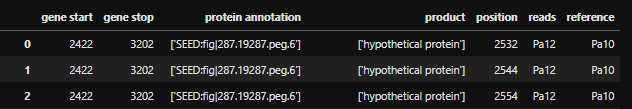

### just an example

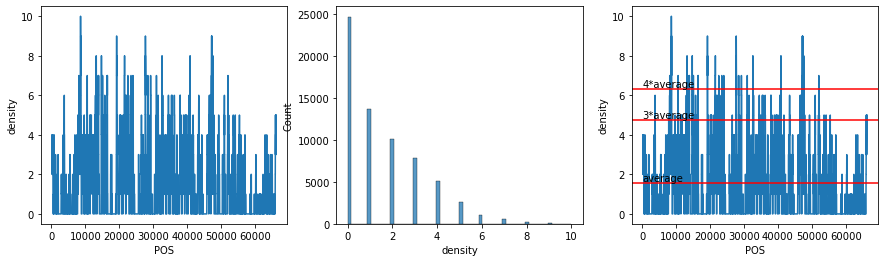

In [7]:
#plot the density
fig, axes = plt.subplots(1,3, figsize = (15,4))
#first plot
sns.lineplot(data = read_ref_snp_df_filled, x= 'POS', y= 'density', ax = axes[0])
#second plot 
sns.histplot(read_ref_snp_df_filled, x = 'density', ax = axes[1])
#third plot 
average = read_ref_snp_df_filled.loc[:, 'density'].mean()
sns.lineplot(data = read_ref_snp_df_filled, x= 'POS', y= 'density', ax = axes[2])
axes[2].axhline(y = average, color = 'r')
axes[2].text(x = 0, y = average+0.1, s = 'average', fontdict = {'color':'black'})
axes[2].axhline(y = 3*average, color = 'r')
axes[2].text(x = 0, y = 3*average+0.1, s = '3*average', fontdict = {'color':'black'})

axes[2].axhline(y = 4*average, color = 'r', )
axes[2].text(x = 0, y = 4*average+0.1, s = '4*average', fontdict = {'color':'black'})
plt.show()

## data analysis on the snp pos dataset

Which genes are conserved

In [8]:
snp_gene_df = pd.read_csv('pos_gene_start.csv')
snp_gene_df

,gene start,gene stop,protein annotation,product,position,reads,reference
0,61930,64120,['SEED:fig|287.19287.peg.88'],['Phage protein'],64071,Pa12,Pa10
1,61094,61931,['SEED:fig|287.19287.peg.87'],['Phage minor capsid protein'],61607,Pa30,Pa10
2,61094,61931,['SEED:fig|287.19287.peg.87'],['Phage minor capsid protein'],61607,Pa32,Pa10
3,1898,2336,['SEED:fig|287.19287.peg.5'],['hypothetical protein'],2164,Pa33,Pa10
4,1898,2336,['SEED:fig|287.19287.peg.5'],['hypothetical protein'],2169,Pa33,Pa10
...,...,...,...,...,...,...,...
917,27306,27492,['SEED:fig|287.19288.peg.47'],['hypothetical protein'],27314,Pa24,Pa12
918,27306,27492,['SEED:fig|287.19288.peg.47'],['hypothetical protein'],27314,Pa24,Pa12
919,6446,8744,['SEED:fig|287.19288.peg.11'],['Phage protein'],8587,Pa2,Pa12
920,6446,8744,['SEED:fig|287.19288.peg.11'],['Phage protein'],8587,Pa33,Pa12


## make barcode plot

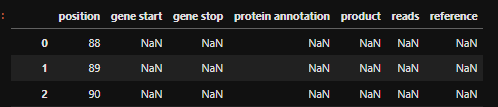

['Pa12' 'Pa21' 'Pa24' 'Pa2' 'Pa30' 'Pa32' 'Pa34' 'Pa35' 'Pa49' 'Pa10']


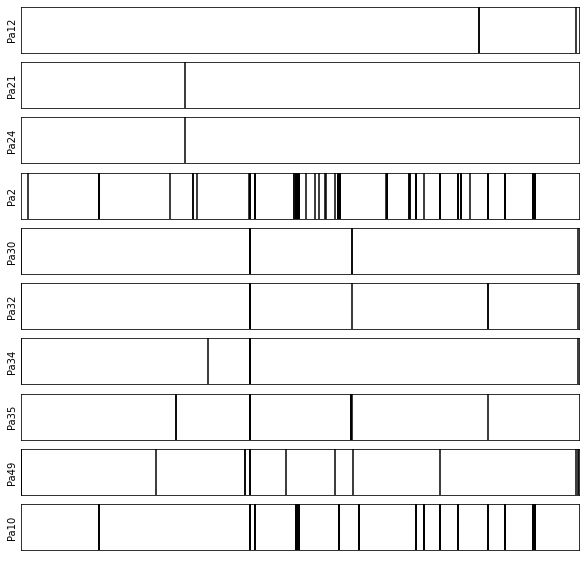

In [11]:
phage = 'Pa33'
ref_snp_gene_df = snp_gene_df[snp_gene_df.loc[:, 'reference'] == phage]
minimum = ref_snp_gene_df.loc[:, 'position'].min()
maximum = ref_snp_gene_df.loc[:, 'position'].max()
#barcode_df = read_ref_snp_gene_df[['position']]


reads_array = ref_snp_gene_df.loc[:, 'reads'].unique()

fig, axes = plt.subplots(len(reads_array),1, figsize =(10,10))

print(reads_array)
for i in range(len(reads_array)): 
    reads = reads_array[i]
    read_ref_snp_gene_df = ref_snp_gene_df[ref_snp_gene_df.loc[:, 'reads'] == reads].reset_index()

    # only one line may be specified; full height
    for ii in range(read_ref_snp_gene_df.shape[0]): 
        position = read_ref_snp_gene_df.loc[ii, 'position']
        try: 
            axes[i].axvline(x = position, color = 'black', label = 'axvline - full height')
            axes[i].set_xticks([])
            axes[i].set_ylabel(reads, rotation = 90)    
            axes[i].set_xlim(minimum, maximum)
            axes[i].set_yticks([])
        except: 
            continue
plt.show()

In [10]:
phage = 'Pa10'
reads = 'Pa12'
ref_snp_gene_df = snp_gene_df[snp_gene_df.loc[:, 'reference'] == phage]
minimum = ref_snp_gene_df.loc[:, 'position'].min()
maximum = ref_snp_gene_df.loc[:, 'position'].max()
barcode_df = read_ref_snp_gene_df[['position']]


reads_array = ref_snp_gene_df.loc[:, 'reads'].unique()

fig, axes = plt.subplots(len(reads_array),1)          
            
                         
# for i in reads_array:
      read                  
#     read_ref_snp_gene_df = ref_snp_gene_df[ref_snp_gene_df.loc[:, 'reads'] == reads].reset_index()

#     # only one line may be specified; full height
#     for ii in range(read_ref_snp_gene_df.shape[0]): 
#         position = read_ref_snp_gene_df.loc[ii, 'position']
#         axes[i].axvline(x = position, color = 'black', label = 'axvline - full height')

#     axes[i].set_xticks([])
#     axes[i].set_ylabel(reads)    
#     axes[i].set_xlim(minimum, maximum)
#     plt.show()

IndentationError: unexpected indent (Temp/ipykernel_23340/2981307146.py, line 15)

In [ ]:


# specifying the plot size
plt.figure(figsize = (10,1))
 
# only one line may be specified; full height
for ii in range(read_ref_snp_gene_df.shape[0]): 
    position = read_ref_snp_gene_df.loc[ii, 'position']
    plt.axvline(x = position, color = 'black', label = 'axvline - full height')
plt.xlabel('position')
plt.ylabel(reads)
plt.yticks([])
plt.xticks([])

In [ ]:
sns.barplot(data = filled_df, x = 'index', y = 'notna')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

# the bar
x = np.random.rand(500) > 0.7

barprops = dict(aspect='auto' ,cmap='binary')

fig = plt.figure()

# a vertical barcode
ax2 = fig.add_axes([0.6, 0.4, 2, 0.2])
ax2.set_axis_off()
ax2.imshow(x.reshape((1, -1)), **barprops)
barcode_array = np.array(filled_df.loc[:, 'product'].notna())
reshaped_barcode_array = barcode_array.reshape(1, len(barcode_array))

ax2.imshow(reshaped_barcode_array, **barprops)

In [ ]:
sns.scatterplot(x = np.arange(0, len(barcode_array),1), y = barcode_array)

In [ ]:
sns.barplot()

In [ ]:
x.reshape((1, -1)).shape

In [ ]:
barcode_array = np.array(filled_df.loc[:, 'product'].notna())
reshaped_barcode_array = barcode_array.reshape(1, len(barcode_array))

In [ ]:
reshaped_barcode_array.shape

In [ ]:
x.reshape(1, -1)

In [ ]:
reshaped_barcode_array[0:500]